In [18]:
%load_ext autoreload
%autoreload 2
from wiki_dataset import WikiDataset
from vector_database import VectorDatabase
from torch.utils.data import DataLoader
from fever_dataset import FeverDataset, FeverCollator
from models import EmbeddingGenerator, NLI

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
wiki_dataset = WikiDataset(reduced=True, in_mem=True, num_extra_pages=0, seed=0)
wiki_dataloader = DataLoader(wiki_dataset, batch_size=8196, num_workers=8, shuffle=False)

In [4]:
emb_gen = EmbeddingGenerator()
vdb = VectorDatabase(wiki_loader=wiki_dataloader, emb_gen=emb_gen, host='docker', version='vx')

Creating collection
Block 1/2 done
Block 2/2 done
Time to create collection: 43.42339301109314


In [21]:
# get a random page
ids = wiki_dataloader.dataset.get_random_ids(10)
ids

#vdb.client.retrieve(collection_name='vx', ids=ids, with_payload=True, with_vectors=False)

[{'id': 'Bombing_of_Guernica',
  'text': "The bombing of Guernica -LRB- 26 April 1937 -RRB- was an aerial bombing of the Basque town of Guernica during the Spanish Civil War . It was carried out at the behest of Francisco Franco 's nationalist government by its allies , the Nazi German Luftwaffe 's Condor Legion and the Fascist Italian Aviazione Legionaria , under the code name Operation Rügen . The town was being used as a communications center behind the frontline .   The attack gained infamy because it involved the bombing of civilians by a military air force . The number of victims is still disputed ; the Basque government reported 1,654 people killed at the time , while local historians identified 126 victims -LRB- later revised by the authors of the study to 153 -RRB- . An English source used by the Air War College claims 400 civilians died . Russian archives claim 800 deaths on 1 May 1937 , but this number may not include victims who later died of their injuries in hospitals or 

## Real

In [23]:
%load_ext autoreload
%autoreload 2
from wiki_dataset import WikiDataset
from vector_database import VectorDatabase
from torch.utils.data import DataLoader
from fever_dataset import FeverDataset, FeverCollator
from models2 import EmbeddingGenerator, NLI
from validation import Validation
from train import Train
import torch
from other_utils import print_progress

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_EPOCHS = 5
NUM_EXTRA_PAGES = 0

fever_collator = FeverCollator()
train_fever_dataset = FeverDataset(type='train')
train_fever_loader = DataLoader(train_fever_dataset, batch_size=10, num_workers=8, shuffle=True, collate_fn=fever_collator)
eval_fever_dataset = FeverDataset(type='eval')
eval_fever_loader = DataLoader(eval_fever_dataset, batch_size=64, num_workers=8, shuffle=False, collate_fn=fever_collator)
wiki_dataset = WikiDataset(reduced=True, in_mem=True, num_extra_pages=NUM_EXTRA_PAGES, seed=None)
wiki_dataloader = DataLoader(wiki_dataset, batch_size=8196, num_workers=8, shuffle=False)

emb_gen = EmbeddingGenerator()
nli = NLI()


loss_fn1 = torch.nn.CosineEmbeddingLoss(margin=0.2)
loss_fn2 = torch.nn.BCEWithLogitsLoss()

# a fussed optimizer
optimizer = torch.optim.AdamW([
    {'params': emb_gen.parameters(), 'lr': 1e-5},
    {'params': nli.parameters(), 'lr': 1e-4}
], fused=True)

tracking_eval = {'nli_accuracy': [], 
                'nli_f1': [], 
                'overall_accuracy': [], 
                'overall_f1': [], 
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [], 
                'average_loss2':  [],
                'average_total_loss': []}


tracking_train = {'nli_accuracy': [], 
                'nli_f1': [], 
                'overall_accuracy': [], 
                'overall_f1': [], 
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [], 
                'average_loss2':  [],
                'average_total_loss': []}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
train_fever_loader = DataLoader(train_fever_dataset, batch_size=64, num_workers=8, shuffle=True, collate_fn=fever_collator)

Epoch: 0
Batch: 1579/2046


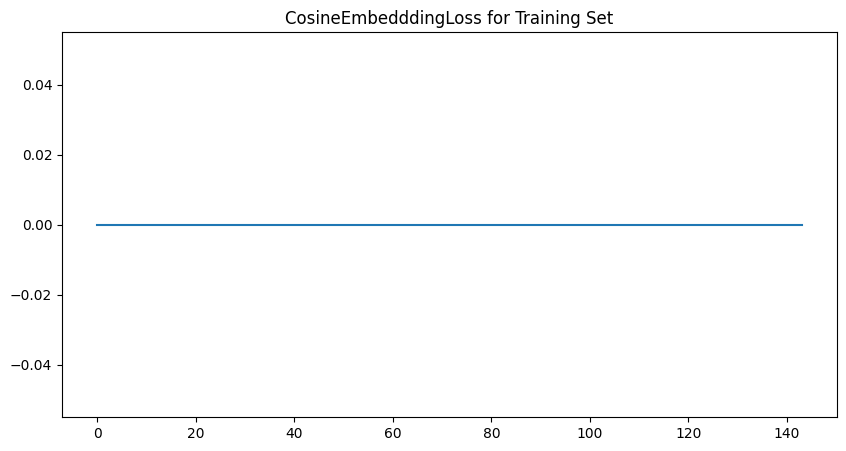

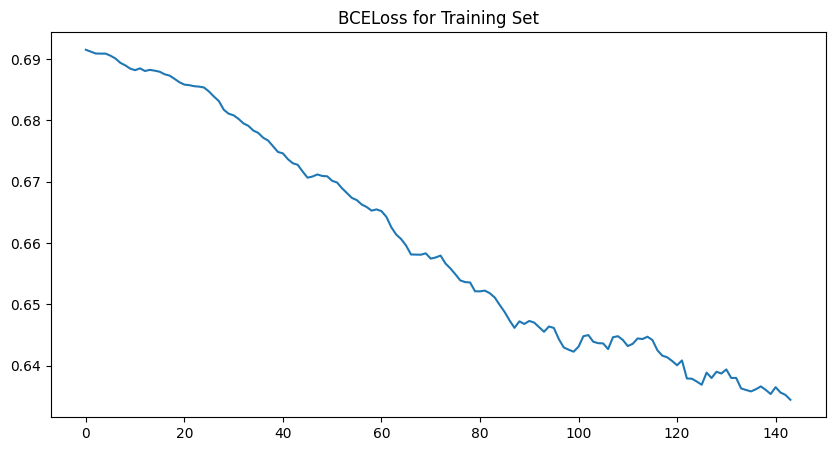

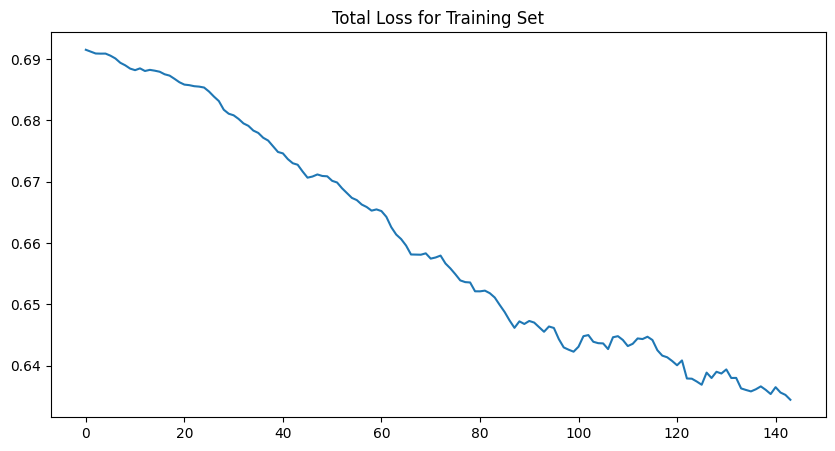

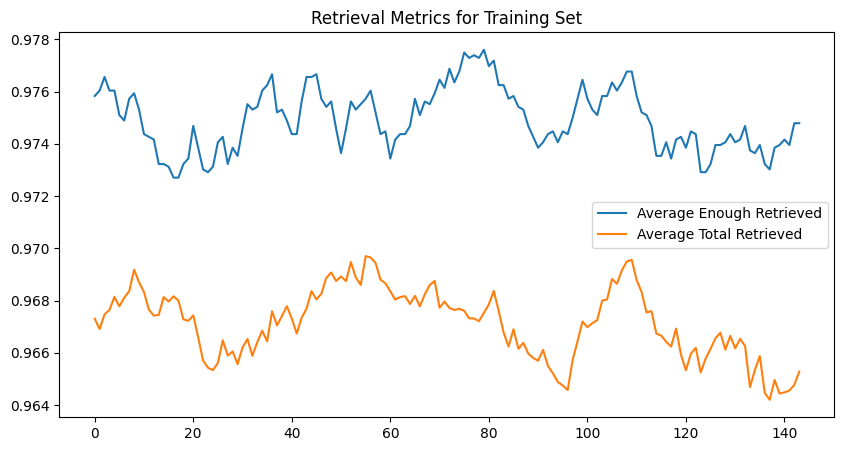

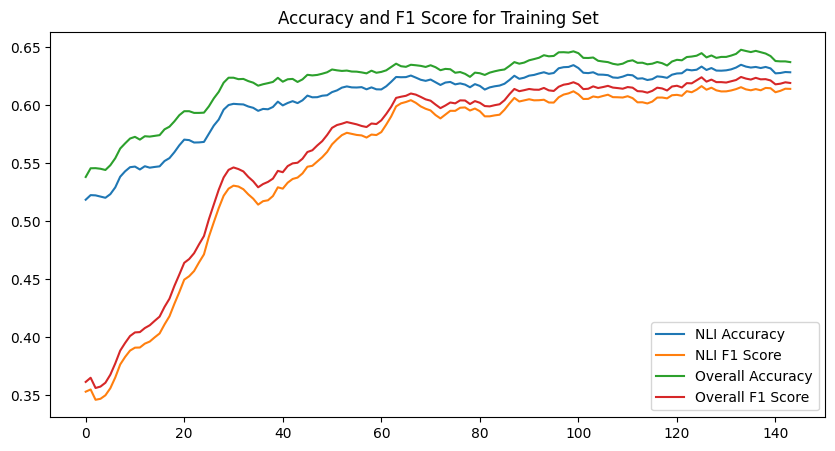

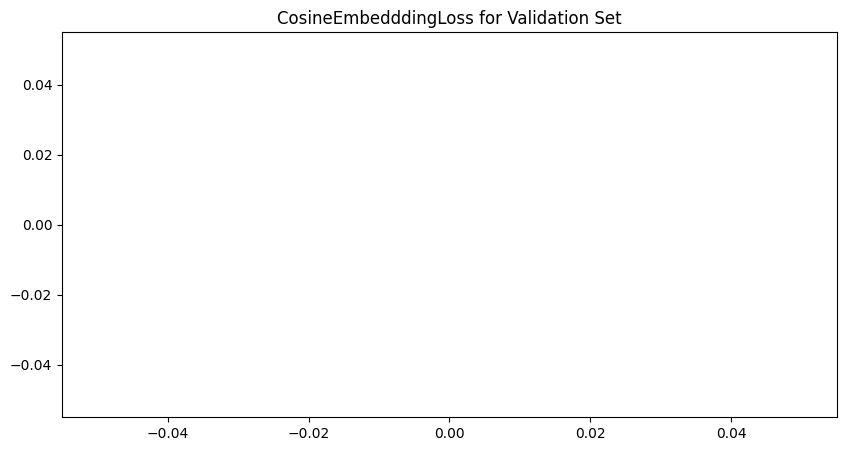

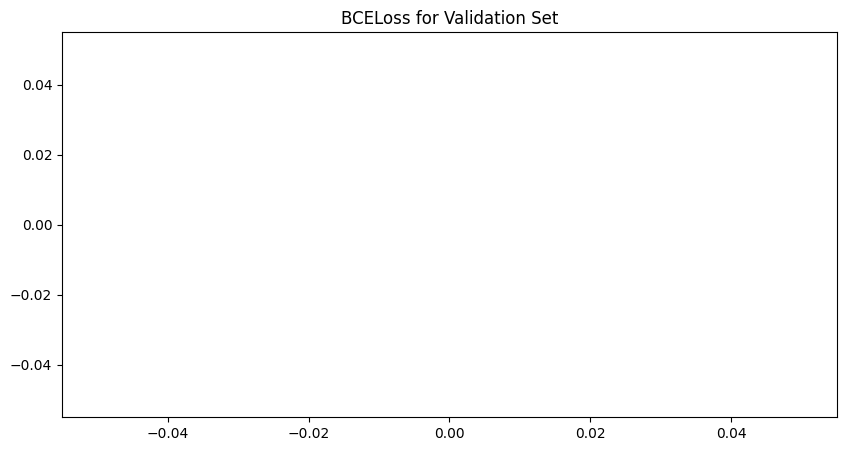

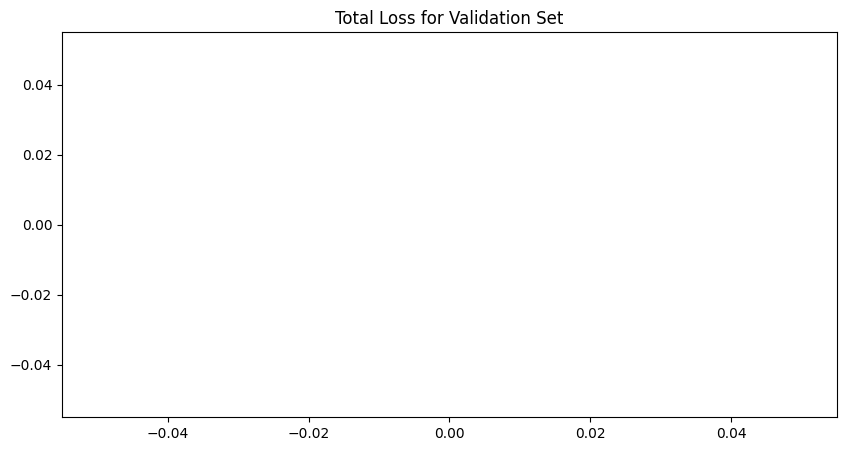

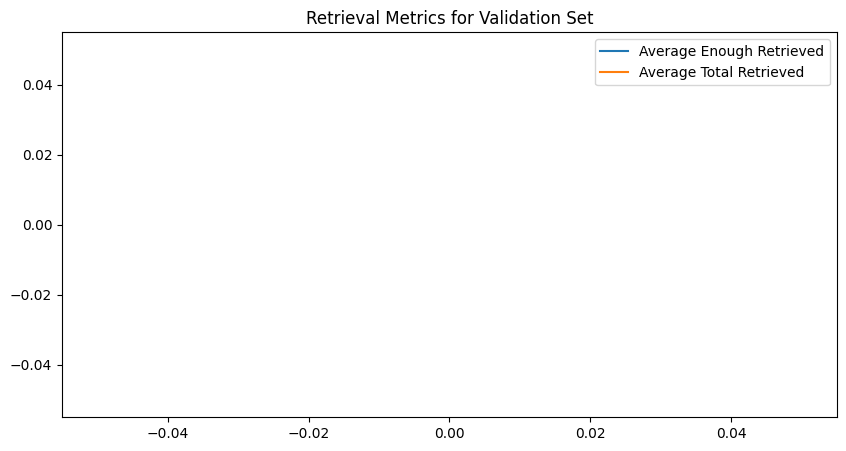

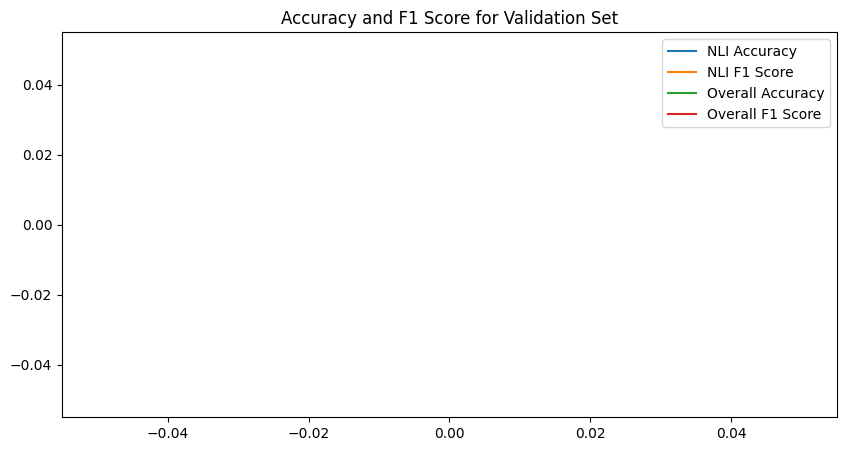

{'preds': [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0], 'original_labels': [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0], 'dynamic_labels': [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0], 'percentage_retrieved': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 0.8333333333333334, 1

KeyboardInterrupt: 

In [25]:
val = Validation(device=device, eval_loader=eval_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, model_name='test')
train = Train(device=device, train_loader=train_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, optimizer=optimizer, model_name='test')

vdb = VectorDatabase(wiki_loader=wiki_dataloader, emb_gen=emb_gen, host='docker')
#val.valid_epoch(vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
print_progress(epoch=0, batch=1, num_total_batches=1, tracking_eval=tracking_eval, ma_ratio=None)
for epoch in range(N_EPOCHS):
    train.train_epoch(epoch=epoch, vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_train=tracking_train, tracking_eval=tracking_eval, super_batch=10, vdb_refresh_rate=500000)
    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_train=tracking_train, tracking_eval=tracking_eval, ma_ratio=0.1)
    #val.valid_epoch(vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_train=tracking_train, tracking_eval=tracking_eval, ma_ratio=0.1)
    vdb.refresh(emb_gen)

In [ ]:
# sva the NLI model
torch.save(nli.state_dict(), 'models/nli_v0.pth')

In [20]:
# saVE dicts tracking to file, create if file does not exist
import json
with open('results/NLI_v0/tracking_train_v0.json', 'w') as f:
    json.dump(tracking_train, f)


## Real 2

In [2]:
import torch

loss_fn1 = torch.nn.CrossEntropyLoss()

scores = torch.tensor([[0.6, 0.4], [0.8, 0.2]]) * 1
labels = torch.tensor([[1, 0], [1, 0]], dtype=torch.float32)

loss_fn1(scores, labels)


tensor(0.5178)

In [5]:
loss_fn1 = torch.nn.CosineEmbeddingLoss(margin=0)

embedding1 = torch.tensor([[0.6, 0.4], [0.8, 0.2], [0.6, 0.4]])
embedding2 = torch.tensor([[0.6, 0.4], [0.8, 0.2], [-0.2, 0.3]])
target = torch.tensor([1, 1, 1])

loss_fn1(embedding1, embedding2, target)


tensor(0.3333)

In [1]:
%load_ext autoreload
%autoreload 2
from wiki_dataset import WikiDataset
from vector_database import VectorDatabase
from torch.utils.data import DataLoader
from fever_dataset import FeverDataset, FeverCollator
from models import EmbeddingGenerator, NLI
from validation2 import Validation
from train2 import Train
from other_utils import print_progress
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_EPOCHS = 2
NUM_EXTRA_PAGES = 0

fever_collator = FeverCollator()
train_fever_dataset = FeverDataset(type='train')
train_fever_loader = DataLoader(train_fever_dataset, batch_size=len(train_fever_dataset), num_workers=8, shuffle=False, collate_fn=fever_collator, pin_memory=True)
eval_fever_dataset = FeverDataset(type='eval')
eval_fever_loader = DataLoader(eval_fever_dataset, len(train_fever_dataset), num_workers=8, shuffle=False, collate_fn=fever_collator, pin_memory=True)
wiki_dataset = WikiDataset(reduced=False, in_mem=False, num_extra_pages=NUM_EXTRA_PAGES, seed=0)
wiki_dataloader = DataLoader(wiki_dataset, batch_size=8196, num_workers=8, shuffle=False, pin_memory=True)

emb_gen = EmbeddingGenerator(device=device)
nli = NLI(device=device)


loss_fn1 = torch.nn.CosineEmbeddingLoss(margin=0.25)
#loss_fn1 = torch.nn.CrossEntropyLoss()
loss_fn2 = torch.nn.BCEWithLogitsLoss()

# a fussed optimizer
optimizer = torch.optim.AdamW([
    #{'params': emb_gen.parameters(), 'lr': 5e-6},
    {'params': nli.parameters(), 'lr': 1e-4}
], fused=True)


tracking_eval = {'nli_accuracy': [], 
                'nli_f1': [], 
                'overall_accuracy': [], 
                'overall_f1': [], 
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [], 
                'average_loss2':  [],
                'average_total_loss': []}


tracking_train = {'nli_accuracy': [], 
                'nli_f1': [], 
                'overall_accuracy': [], 
                'overall_f1': [], 
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [], 
                'average_loss2':  [],
                'average_total_loss': []}

In [2]:
import json
# load dictionaries from file
with open('metrics/tracking_train_v0.json', 'r') as f:
    tracking_train = json.load(f)

with open('metrics/tracking_eval_v0.json', 'r') as f:
    tracking_eval = json.load(f)

In [2]:
# load models
emb_gen.load_state_dict(torch.load('models/emb_gen_v1.pth'))
#nli.load_state_dict(torch.load('models/nli_v1.pth'))

<All keys matched successfully>

Epoch: 0
Batch: 1023/16363


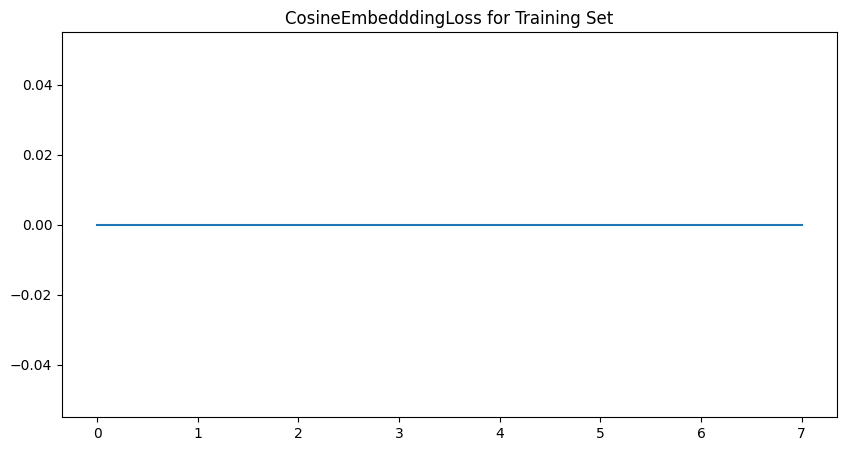

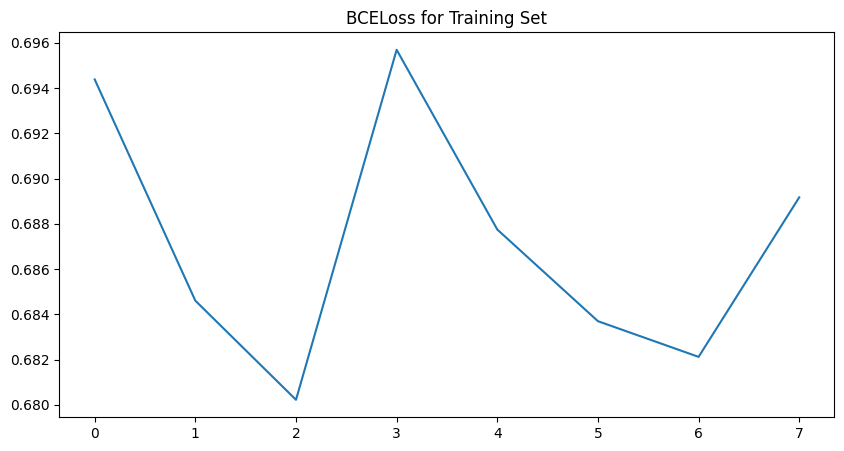

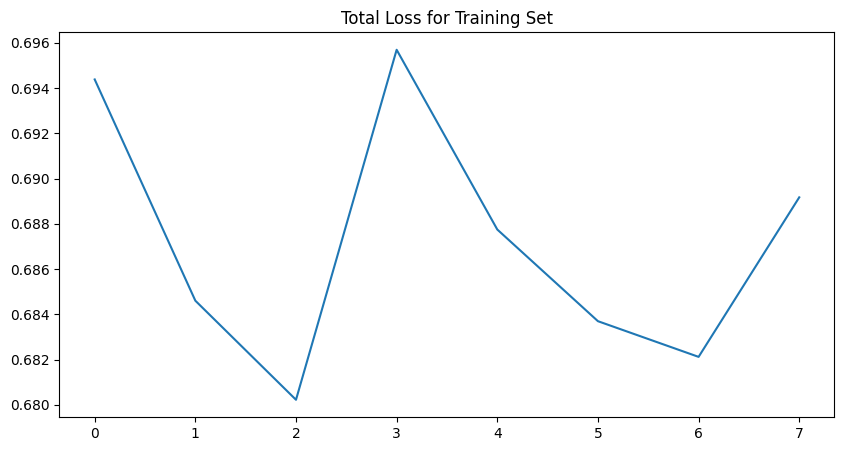

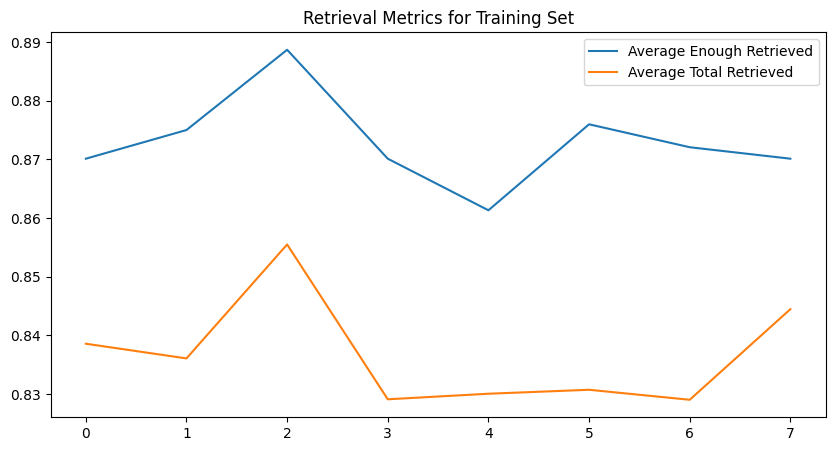

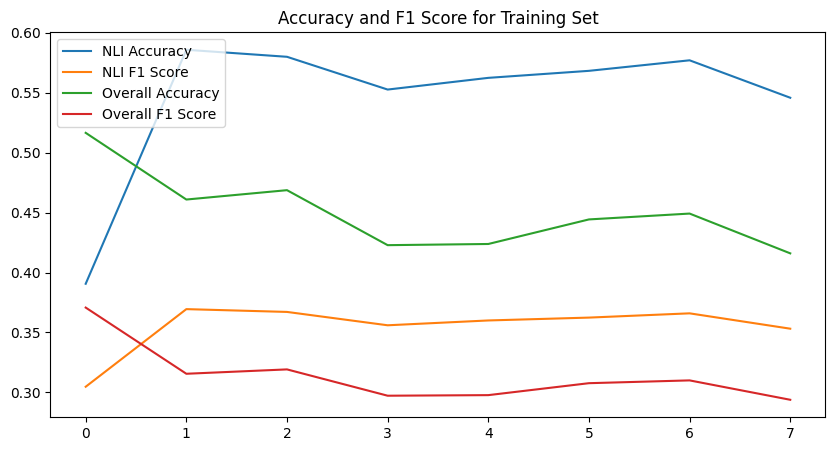

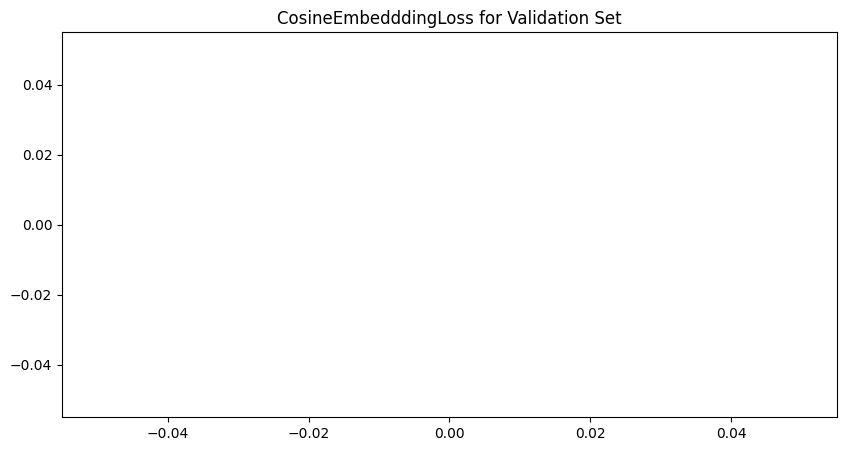

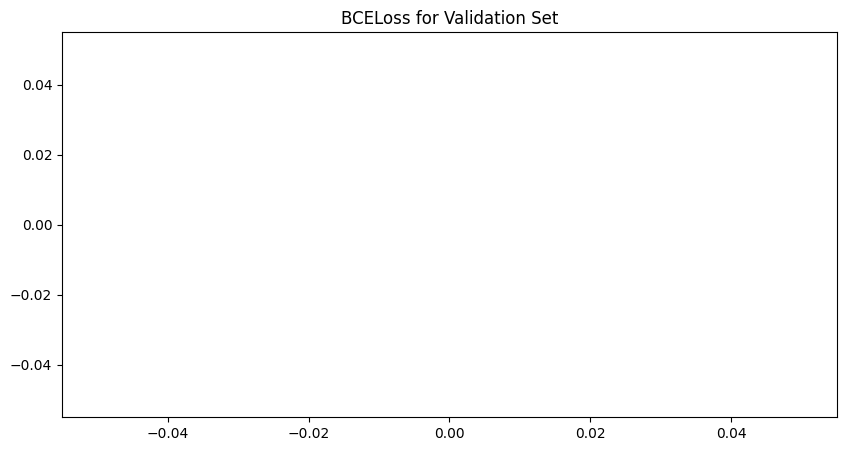

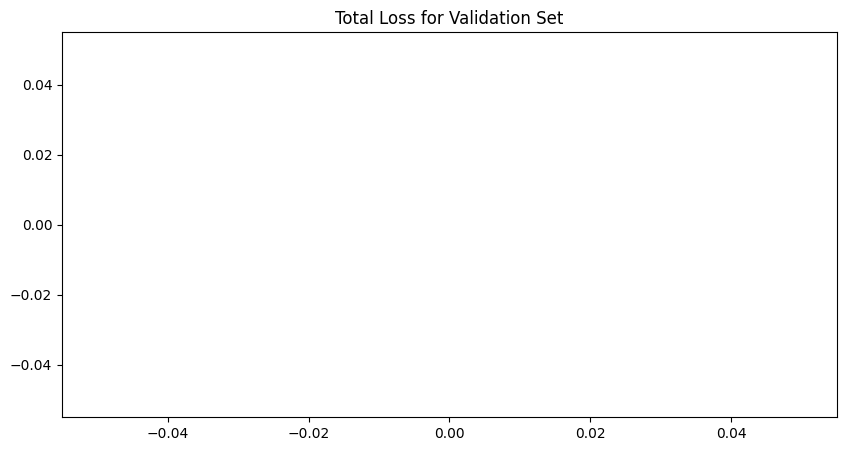

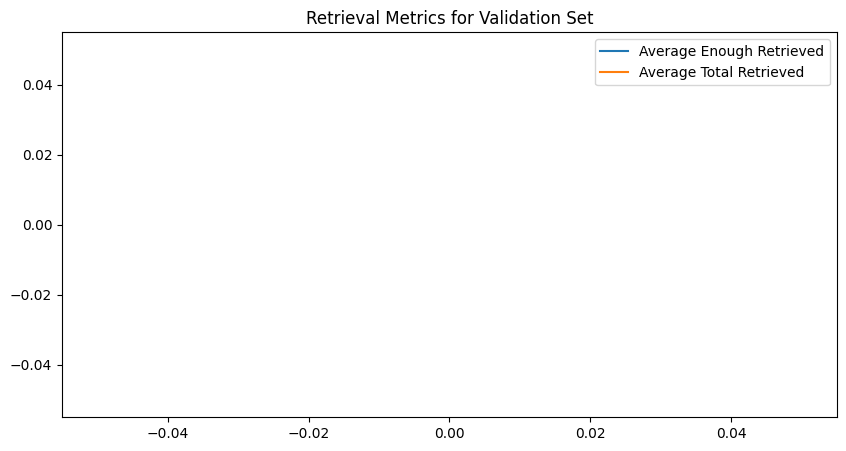

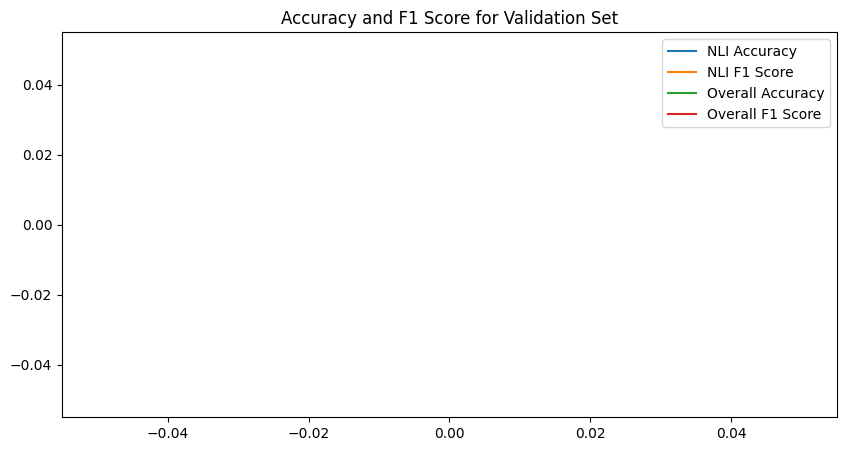

{'preds': [0, 0, 0, 0, 0, 0, 0, 0], 'original_labels': [0, 0, 0, 1, 0, 1, 1, 0], 'dynamic_labels': [0, 0, 0, 1, 0, 0, 1, 0], 'percentage_retrieved': [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0], 'loss1': 0.0, 'loss2': 0.6489702463150024, 'total_loss': 0.6489702463150024}
{'preds': [0, 0, 0, 0, 0, 0, 0, 0], 'original_labels': [0, 1, 1, 1, 1, 1, 0, 0], 'dynamic_labels': [0, 1, 0, 1, 1, 1, 0, 0], 'percentage_retrieved': [1.0, 1.0, 0.0, 0.5, 1.0, 1.0, 1.0, 1.0], 'loss1': 0.0, 'loss2': 0.7021353244781494, 'total_loss': 0.7021353244781494}
{'preds': [0, 0, 0, 0, 0, 0, 0, 0], 'original_labels': [0, 1, 0, 1, 0, 0, 0, 1], 'dynamic_labels': [0, 1, 0, 1, 0, 0, 0, 0], 'percentage_retrieved': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5], 'loss1': 0.0, 'loss2': 0.6551011204719543, 'total_loss': 0.6551011204719543}
{'preds': [0, 0, 0, 0, 0, 0, 0, 0], 'original_labels': [1, 0, 0, 1, 1, 1, 0, 0], 'dynamic_labels': [0, 0, 0, 1, 1, 1, 0, 0], 'percentage_retrieved': [0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss

KeyboardInterrupt: 

In [3]:
#val = Validation(device=device, eval_loader=eval_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, model_name='test')
train = Train(device=device, train_loader=train_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, optimizer=optimizer, model_name='v1')

vdb = VectorDatabase(wiki_loader=wiki_dataloader, emb_gen=emb_gen, host='docker', version='v1')
#val.valid_epoch(vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
#print_progress(epoch=0, batch=1, num_total_batches=1, tracking_eval=tracking_eval, ma_ratio=None)
for epoch in range(N_EPOCHS):
    train.train_epoch(epoch=epoch, vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_train=tracking_train, tracking_eval=tracking_eval, super_batch=128, ma_ratio=0)
    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_train=tracking_train, tracking_eval=tracking_eval, ma_ratio=0.1)
    #val.valid_epoch(vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
    #print_progress(epoch=0, batch=1, num_total_batches=1, tracking_train=tracking_train, tracking_eval=tracking_eval, ma_ratio=None)

In [ ]:
# save dictionaries to file, create if file does not exist
import json
# with open('metrics/tracking_train_v0.json', 'w') as f:
#     json.dump(tracking_train, f)

# with open('metrics/tracking_eval_v0.json', 'w') as f:
#     json.dump(tracking_eval, f)

In [4]:
# save the model weights
#torch.save(emb_gen.state_dict(), 'models/emb_gen_v1.pth')
#torch.save(nli.state_dict(), 'models/nli_v1.pth')